# IAU Projekt 2.fáza 
### Autori: Peter Plevko (50%), Radovan Cyprich (50%)                                                                        
### Dátum: 21.11.2021

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mat
import matplotlib.pylab as pylab
import statsmodels.api as sm
from sklearn.preprocessing import FunctionTransformer
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms
import scipy.stats as stats
from matplotlib import pyplot
from collections import Counter
from datetime import datetime, date
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler ,MinMaxScaler, PowerTransformer,QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
pd.options.mode.chained_assignment = None
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

# Načítanie údajov z datasetu

In [2]:
ourdataset="061/profiles.csv"
profiles = pd.read_csv(ourdataset, sep='\t')
ourdataset="061/labor.csv"
labor = pd.read_csv(ourdataset, sep='\t')
merged = pd.merge(labor, profiles, on=["ssn", "name"])

## Atribút unnamed

Ako prvé si z datasetu odstránime nepotrebný atribút *Unnamed*, ktorý nám len označuje index záznamu. Vymažeme si ho aj kvôli tomu aby sa nám podarilo zistiť, či sa v datasete nachádzajú nejaké duplicitné záznamy. Tento atribút nemá pre nás žiadnu výpovednú hodnotu.

In [3]:
merged.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, errors='ignore', inplace=True)

In [4]:
merged.head()

,relationship,smoker,alp,weight,trombocyty,hematokrit,hemoglobin,er-cv,ast,ssn,...,alt,etytr,name,residence,blood_group,birthdate,address,race,job,sex
0,divoced,yes,69.29754,96.36107,6.16009,5.43057,5.33106,51.19736,48.65497,470-64-4139,...,4.52772,6.41607,Peter Caldwell,"205 Mary Expressway\nSouth Joseph, MS 59705",B-,03 Oct 2018,"6123 Davis Plain Suite 596\nJoshuaton, WY 57242",Black,Information officer,M
1,single,yes,72.82074,48.08581,5.34360,5.93857,5.38394,55.26958,64.91090,470-64-4139,...,12.80219,6.26050,Peter Caldwell,"205 Mary Expressway\nSouth Joseph, MS 59705",B-,03 Oct 2018,"6123 Davis Plain Suite 596\nJoshuaton, WY 57242",Black,Information officer,M
2,widowed,no,20.71153,84.24071,7.86501,5.29297,8.64115,53.49391,55.51303,470-64-4139,...,6.98207,7.43575,Peter Caldwell,"205 Mary Expressway\nSouth Joseph, MS 59705",B-,03 Oct 2018,"6123 Davis Plain Suite 596\nJoshuaton, WY 57242",Black,Information officer,M
3,married,N,71.48080,78.61777,7.63083,4.34763,7.07119,57.12180,56.47341,470-64-4139,...,5.12203,6.48746,Peter Caldwell,"205 Mary Expressway\nSouth Joseph, MS 59705",B-,03 Oct 2018,"6123 Davis Plain Suite 596\nJoshuaton, WY 57242",Black,Information officer,M
4,separated,yes,77.14564,87.14201,7.56648,5.49149,6.93812,62.31427,41.80988,579-65-9832,...,7.19988,7.18319,Christopher Kirk,"280 Matthew Station\nLake Kevintown, ID 24849",A-,1989/06/30,"PSC 6508, Box 2850\nAPO AP 67161",Asian,Mudlogger,M


## Atribúty sex a smoker

Atribúty sex a smoker, ktoré nám vypovedajú o pravdivostných hodnotách jednotlivých vlastností pacientov, sme si nahradili číselnými atribútmi 1 a 0. Tieto atribúty neobsahujú, žiadne nan hodnoty.

In [5]:
print(len((merged[merged.sex.isnull()])))

0


In [6]:
print(len((merged[merged.smoker.isnull()])))

0


In [7]:
merged['sex'] = merged['sex'].str.replace('M',"1")
merged['sex'] = merged['sex'].str.replace('F',"0")
merged['smoker'] = merged['smoker'].str.replace('yes',"1")
merged['smoker'] = merged['smoker'].str.replace('no',"0")
merged['smoker'] = merged['smoker'].str.replace('Y',"1")
merged['smoker'] = merged['smoker'].str.replace('N',"0")

In [8]:
merged.sex.unique()

array(['1', '0'], dtype=object)

In [9]:
merged.smoker.unique()

array(['1', '0'], dtype=object)

## Vytvorenie atribútu age podľa atribútu birthdate

In [10]:
def monthToNum(shortMonth):
    return {
            'Jan': '01',
            'Feb': '02',
            'Mar': '03',
            'Apr': '04',
            'May': '05',
            'Jun': '06',
            'Jul': '07',
            'Aug': '08',
            'Sep': '09', 
            'Oct': '10',
            'Nov': '11',
            'Dec': '12'
    }[shortMonth]

for x in merged['birthdate']:
    
    # nahradim nulovy datum 
    if(len(x)==20):
        removedZeros = x.replace(", 00:00:00", "")
        array = removedZeros.split("/")
        newString = array[2] + "-" + array[0] + "-" + array[1]
        merged['birthdate'] = merged['birthdate'].replace(x, newString)
    
    # nahradim lomitkovy datum
    elif(len(x)==10):
        merged['birthdate'] = merged['birthdate'].replace(x, x.replace("/", "-"))
        
    # menim slovo mesiac na cislo
    elif(len(x)==11):
        array = x.split(" ")
        newString = array[2] + "-" + monthToNum(array[1]) + "-" + array[0]
        merged['birthdate'] = merged['birthdate'].replace(x, newString)

In [11]:
def age(born):
    born = datetime.strptime(born, "%Y-%m-%d").date()
    today = date.today()
    return today.year - born.year - ((today.month,today.day) < (born.month,born.day))
  
merged['age'] = merged['birthdate'].apply(age)

In [12]:
merged.head()

,relationship,smoker,alp,weight,trombocyty,hematokrit,hemoglobin,er-cv,ast,ssn,...,etytr,name,residence,blood_group,birthdate,address,race,job,sex,age
0,divoced,1,69.29754,96.36107,6.16009,5.43057,5.33106,51.19736,48.65497,470-64-4139,...,6.41607,Peter Caldwell,"205 Mary Expressway\nSouth Joseph, MS 59705",B-,2018-10-03,"6123 Davis Plain Suite 596\nJoshuaton, WY 57242",Black,Information officer,1,3
1,single,1,72.82074,48.08581,5.34360,5.93857,5.38394,55.26958,64.91090,470-64-4139,...,6.26050,Peter Caldwell,"205 Mary Expressway\nSouth Joseph, MS 59705",B-,2018-10-03,"6123 Davis Plain Suite 596\nJoshuaton, WY 57242",Black,Information officer,1,3
2,widowed,0,20.71153,84.24071,7.86501,5.29297,8.64115,53.49391,55.51303,470-64-4139,...,7.43575,Peter Caldwell,"205 Mary Expressway\nSouth Joseph, MS 59705",B-,2018-10-03,"6123 Davis Plain Suite 596\nJoshuaton, WY 57242",Black,Information officer,1,3
3,married,0,71.48080,78.61777,7.63083,4.34763,7.07119,57.12180,56.47341,470-64-4139,...,6.48746,Peter Caldwell,"205 Mary Expressway\nSouth Joseph, MS 59705",B-,2018-10-03,"6123 Davis Plain Suite 596\nJoshuaton, WY 57242",Black,Information officer,1,3
4,separated,1,77.14564,87.14201,7.56648,5.49149,6.93812,62.31427,41.80988,579-65-9832,...,7.18319,Christopher Kirk,"280 Matthew Station\nLake Kevintown, ID 24849",A-,1989-06-30,"PSC 6508, Box 2850\nAPO AP 67161",Asian,Mudlogger,1,32


## Atribút relationship

Keďže strojové učenie nevie pracovať s nenumerickými hodnotami rozhodli sme sa rozdeliť si pacientov na tých, ktorí majú partnera a tých, čo nie. V stĺpci relationship nahradíme hodnoty za 1 pre pacientov, čo majú partnera a 0 pre tých,čo nie.

In [13]:
merged['relationship'] = merged['relationship'].str.replace('divoced',"divorced")

In [14]:
merged['relationship'] = merged['relationship'].str.replace('divorced',"0")
merged['relationship'] = merged['relationship'].str.replace('single',"0")
merged['relationship'] = merged['relationship'].str.replace('separated',"0")
merged['relationship'] = merged['relationship'].str.replace('widowed',"0")
merged['relationship'] = merged['relationship'].str.replace('nop',"0")
merged['relationship'] = merged['relationship'].str.replace('married',"1")

In [15]:
merged.relationship.unique()

array(['0', '1'], dtype=object)

## Atribút race

Chceme docieliť, aby sme aj so string atribútmi mohli pracovať s numerickými atribútmi, preto nahradíme jednotlivé typy rás za čísla.

**Black - 1**

**Asian - 2**

**White - 3**

**Indian - 4**

**Hawaiian - 5**

Nekonzistentné hodnoty najskôr nahradíme správnymi a následne jednotlivé typy rás pretransformujeme na numerické hodnoty.

In [16]:
merged['race'] = merged['race'].astype(str).str.replace('blsck',"Black")
merged['race'] = merged['race'].astype(str).str.replace('black',"Black")
merged['race'] = merged['race'].astype(str).str.replace('white',"White")

In [17]:
merged['race'] = merged['race'].str.replace('Black',"1")
merged['race'] = merged['race'].str.replace('Asian',"2")
merged['race'] = merged['race'].str.replace('White',"3")
merged['race'] = merged['race'].str.replace('Indian',"4")
merged['race'] = merged['race'].str.replace('Hawaiian',"5")

In [18]:
for x in merged['race']:
    if(x=='1'):
        newString = 1
        merged['race'] = merged['race'].replace(x, newString)
    elif(x=='2'):
        newString = 2
        merged['race'] = merged['race'].replace(x, newString)
    elif(x=='3'):
        newString = 3
        merged['race'] = merged['race'].replace(x, newString)
    elif(x=='4'):
        newString = 4
        merged['race'] = merged['race'].replace(x, newString)
    elif(x=='5'):
        newString = 5
        merged['race'] = merged['race'].replace(x, newString)

In [19]:
merged.race.unique()

array([1, 2, 3, 4, 5], dtype=int64)

## Atribút blood_group

Atribút, ktorý nám sprostredkuváva informáciu o type krvnej skupiny pacienta, taktiež pretransformujeme na numerické hodnoty následovným spôsobom.

**A- = -1**

**A+ = 1**

**B- = -2**

**B+ = 2**

**AB- = -3**

**AB+ = 3**

**O- = -4**

**O+ = 4**


In [20]:
merged['blood_group'] = merged['blood_group'].str.replace('AB-',"-3")
merged['blood_group'] = merged['blood_group'].str.replace('AB+','3')

merged['blood_group'] = merged['blood_group'].str.replace('A-',"-1")
merged['blood_group'] = merged['blood_group'].str.replace('A+',"1")

merged['blood_group'] = merged['blood_group'].str.replace('B-',"-2")
merged['blood_group'] = merged['blood_group'].str.replace('B+',"2")

merged['blood_group'] = merged['blood_group'].str.replace('O-',"-4")
merged['blood_group'] = merged['blood_group'].str.replace('O+',"4")

C:\Users\radov\AppData\Local\Temp/ipykernel_20264/4292570525.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  merged['blood_group'] = merged['blood_group'].str.replace('AB+','3')
C:\Users\radov\AppData\Local\Temp/ipykernel_20264/4292570525.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  merged['blood_group'] = merged['blood_group'].str.replace('A+',"1")
C:\Users\radov\AppData\Local\Temp/ipykernel_20264/4292570525.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  merged['blood_group'] = merged['blood_group'].str.replace('B+',"2")
C:\Users\radov\AppData\Local\Temp/ipykernel_20264/4292570525.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  merged['blood_group'] = merged['blood_group'].str.replace('O+',"4")


In [21]:
for x in merged['blood_group']:
    if(x=='1+'):
        newString = 1
        merged['blood_group'] = merged['blood_group'].replace(x, newString)
    elif(x=='2+'):
        newString = 2
        merged['blood_group'] = merged['blood_group'].replace(x, newString)
    elif(x=='3+'):
        newString = 3
        merged['blood_group'] = merged['blood_group'].replace(x, newString)
    elif(x=='4+'):
        newString = 4
        merged['blood_group'] = merged['blood_group'].replace(x, newString)

In [22]:
merged.blood_group.unique()

array(['-2', '-1', 1, 3, '-3', '-4', 2, 4], dtype=object)

## Atribút weight

V stĺpci *weight*, ktorý reprezentuje hodnotu váhy človeka sme sa rozhodli vylúčiť hodnoty menšie ako 3, keďže novorodenci majú pri narodení okolo troch kíl. Počet týchto záznamov je 241.

In [23]:
minusWeight = merged.loc[merged['weight'] < 3]
print(len(minusWeight))
index_weight = merged[ merged['weight'] < 3 ].index
merged.drop(index_weight, inplace = True)

241


## Atribút job

V tomto stĺpci sa nachádza veľmi veľa podobných hodnôt, ako napríklad viacero typov učiteľov, inžinierov, doktorov, IT špecialostov a ďalších, avšak povolania nám ponúkajú jedinečnú informáciu. Preto sme sa rozhodli tento atribút netransformovať.

Ako máme možnosť vidieť v datasete sa nachádza 

In [24]:
a=len(merged['job'].unique())
merged['job'].unique()
print("Počet unikátnych jobov: " +str(a))
print(merged['job'].unique())

Počet unikátnych jobov: 636
['Information officer' 'Mudlogger' 'Runner, broadcasting/film/video'
 'Technical sales engineer' 'Scientific laboratory technician'
 'Television camera operator' 'Fast food restaurant manager'
 'Medical technical officer' 'Writer' 'Leisure centre manager'
 'Nature conservation officer' 'Advertising account planner'
 'Air cabin crew' 'Special effects artist' 'Passenger transport manager'
 'Surveyor, minerals' 'Publishing rights manager' 'Financial trader'
 'Conference centre manager' 'Consulting civil engineer'
 'Further education lecturer' 'Conservator, furniture' 'Firefighter'
 'Engineer, production' 'Scientist, audiological' 'Engineering geologist'
 'Health and safety adviser' 'Occupational hygienist'
 'Engineer, agricultural' 'Photographer' 'Administrator, arts'
 'Engineer, structural' 'Primary school teacher' 'Barista'
 'Aeronautical engineer' 'Operations geologist' 'Customer service manager'
 'Museum/gallery exhibitions officer' 'Corporate investment ba

In [25]:
merged.head()

,relationship,smoker,alp,weight,trombocyty,hematokrit,hemoglobin,er-cv,ast,ssn,...,etytr,name,residence,blood_group,birthdate,address,race,job,sex,age
0,0,1,69.29754,96.36107,6.16009,5.43057,5.33106,51.19736,48.65497,470-64-4139,...,6.41607,Peter Caldwell,"205 Mary Expressway\nSouth Joseph, MS 59705",-2,2018-10-03,"6123 Davis Plain Suite 596\nJoshuaton, WY 57242",1,Information officer,1,3
1,0,1,72.82074,48.08581,5.34360,5.93857,5.38394,55.26958,64.91090,470-64-4139,...,6.26050,Peter Caldwell,"205 Mary Expressway\nSouth Joseph, MS 59705",-2,2018-10-03,"6123 Davis Plain Suite 596\nJoshuaton, WY 57242",1,Information officer,1,3
2,0,0,20.71153,84.24071,7.86501,5.29297,8.64115,53.49391,55.51303,470-64-4139,...,7.43575,Peter Caldwell,"205 Mary Expressway\nSouth Joseph, MS 59705",-2,2018-10-03,"6123 Davis Plain Suite 596\nJoshuaton, WY 57242",1,Information officer,1,3
3,1,0,71.48080,78.61777,7.63083,4.34763,7.07119,57.12180,56.47341,470-64-4139,...,6.48746,Peter Caldwell,"205 Mary Expressway\nSouth Joseph, MS 59705",-2,2018-10-03,"6123 Davis Plain Suite 596\nJoshuaton, WY 57242",1,Information officer,1,3
4,0,1,77.14564,87.14201,7.56648,5.49149,6.93812,62.31427,41.80988,579-65-9832,...,7.18319,Christopher Kirk,"280 Matthew Station\nLake Kevintown, ID 24849",-1,1989-06-30,"PSC 6508, Box 2850\nAPO AP 67161",2,Mudlogger,1,32


## Nahradenie chýbajúcich hodnôt 

Ako máme možnosť vidieť, v niektorých stĺpcoch máme chýbajúce hodnoty a preto ich musíme nahradiť, zmysluplnými technikami.

In [26]:
merged.isnull().sum()

relationship     0
smoker           0
alp             30
weight           0
trombocyty      28
hematokrit      28
hemoglobin      32
er-cv           30
ast             29
ssn              0
erytrocyty      30
indicator        0
hbver           29
leukocyty       31
alt             29
etytr           30
name             0
residence        0
blood_group      0
birthdate        0
address          0
race             0
job              0
sex              0
age              0
dtype: int64

Z minulej fázy vieme, že niektoré atribúty majú veľmi nízku koreláciu s ostatnými tak preto sme sa rozhodli, že nám nebudú chýbať a odstránime ich.

In [27]:
def drop_na(data):
    data=data.dropna(subset=['er-cv','hbver','etytr','ast'])
    return data
merged=drop_na(merged)

Chýbajúce hodnoty v stĺpcoch *leukocyty, erytrocyty a trombocyty* sme nahradili ich priemerom.

In [28]:
def replace_for_mean(data):
    leukocytyMean = data['leukocyty'].mean()
    data['leukocyty'] = data['leukocyty'].fillna(leukocytyMean)
    erytrocytyMean = data['erytrocyty'].mean()
    data['erytrocyty'] = data['erytrocyty'].fillna(erytrocytyMean)
    trombocytyMean = data['trombocyty'].mean()
    data['trombocyty'] = data['trombocyty'].fillna(trombocytyMean)
mean=replace_for_mean(merged)

Chýbajúce hodnoty v stĺpcoch alt a alp sme nahradili mediánom týchto hodnôt na základe ich korelácie z minulej fázy, pre spestrenie dát.

In [29]:
def replace_for_median(data):
    altMedian = data['alt'].median()
    data['alt'] = data['alt'].fillna(altMedian)
    alpMedian = data['alp'].median()
    data['alp'] = data['alp'].fillna(alpMedian)
median=replace_for_median(merged)

Využili sme KNN algorytmus na transformovanie chýbajúcich hodnôt v stĺpcoch hematokrit a hemoglobin.

In [30]:
def replace_for_KNN(data):
    imputer = KNNImputer()
    imputed_data = pd.DataFrame(imputer.fit_transform(data[['hematokrit','hemoglobin']]))
    data['hematokrit']=imputed_data[0].values
    data['hemoglobin']=imputed_data[1].values
knn=replace_for_KNN(merged)

Na odstránenie nullových hodnôt sme použili pipeline, kde sme postupne nahádzali všetky metódy, ktorými sme nahradzovanie vykonávali. 

In [31]:
pajp = Pipeline([("mean", mean),
                ("median", median),
                ("knn", knn)])
x=pajp.fit_transform(merged)
x

,relationship,smoker,alp,weight,trombocyty,hematokrit,hemoglobin,er-cv,ast,ssn,...,etytr,name,residence,blood_group,birthdate,address,race,job,sex,age
0,0,1,69.29754,96.36107,6.16009,5.43057,5.33106,51.19736,48.65497,470-64-4139,...,6.41607,Peter Caldwell,"205 Mary Expressway\nSouth Joseph, MS 59705",-2,2018-10-03,"6123 Davis Plain Suite 596\nJoshuaton, WY 57242",1,Information officer,1,3
1,0,1,72.82074,48.08581,5.34360,5.93857,5.38394,55.26958,64.91090,470-64-4139,...,6.26050,Peter Caldwell,"205 Mary Expressway\nSouth Joseph, MS 59705",-2,2018-10-03,"6123 Davis Plain Suite 596\nJoshuaton, WY 57242",1,Information officer,1,3
2,0,0,20.71153,84.24071,7.86501,5.29297,8.64115,53.49391,55.51303,470-64-4139,...,7.43575,Peter Caldwell,"205 Mary Expressway\nSouth Joseph, MS 59705",-2,2018-10-03,"6123 Davis Plain Suite 596\nJoshuaton, WY 57242",1,Information officer,1,3
3,1,0,71.48080,78.61777,7.63083,4.34763,7.07119,57.12180,56.47341,470-64-4139,...,6.48746,Peter Caldwell,"205 Mary Expressway\nSouth Joseph, MS 59705",-2,2018-10-03,"6123 Davis Plain Suite 596\nJoshuaton, WY 57242",1,Information officer,1,3
4,0,1,77.14564,87.14201,7.56648,5.49149,6.93812,62.31427,41.80988,579-65-9832,...,7.18319,Christopher Kirk,"280 Matthew Station\nLake Kevintown, ID 24849",-1,1989-06-30,"PSC 6508, Box 2850\nAPO AP 67161",2,Mudlogger,1,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10035,0,0,74.89102,82.05553,7.67858,4.75737,7.30577,53.86889,49.51105,333-49-0424,...,7.07252,Kathleen Mckenzie MD,"562 Howard Point\nNew Jenniferton, NE 92252",3,2005-12-14,"107 Braun Hollow\nMooreland, MN 70674",4,Catering manager,0,15
10036,0,1,29.36845,69.77004,8.13976,5.27482,8.35276,53.56962,21.92280,333-49-0424,...,6.46613,Kathleen Mckenzie MD,"562 Howard Point\nNew Jenniferton, NE 92252",3,2005-12-14,"107 Braun Hollow\nMooreland, MN 70674",4,Catering manager,0,15
10037,0,1,83.47303,91.44586,8.38149,2.79353,6.55380,61.89518,57.47065,333-49-0424,...,5.11583,Kathleen Mckenzie MD,"562 Howard Point\nNew Jenniferton, NE 92252",3,2005-12-14,"107 Braun Hollow\nMooreland, MN 70674",4,Catering manager,0,15
10039,0,1,32.35026,91.62537,7.99131,5.47887,4.27690,45.04191,43.02955,440-35-9806,...,5.63648,Arthur Jackson,8263 Kenneth Mission Suite 014\nEast Robertche...,-1,1975-12-29,"263 Hughes Courts\nLake Nicholasbury, MS 65686",1,"Scientist, research (medical)",1,45


In [32]:
merged.isnull().sum()

relationship    0
smoker          0
alp             0
weight          0
trombocyty      0
hematokrit      0
hemoglobin      0
er-cv           0
ast             0
ssn             0
erytrocyty      0
indicator       0
hbver           0
leukocyty       0
alt             0
etytr           0
name            0
residence       0
blood_group     0
birthdate       0
address         0
race            0
job             0
sex             0
age             0
dtype: int64

## Odstráňovanie duplicitných záznamov

Odstránili sme 98 záznamov, ktoré boli identické s nejakým iným záznamom z datasetu.

In [33]:
duplicates = merged[merged.duplicated()]
merged = merged.drop_duplicates()
print("Počet záznamov v datasete: "+str(len(merged)))
print("V datasete sa nachádza: " + str(len(duplicates)) + " duplikátov.")

Počet záznamov v datasete: 9585
V datasete sa nachádza: 98 duplikátov.


Nachádza sa tu aj viac rovnakých záznamov o jednom pacientovi alebo jednoducho sú to len menovci.

In [34]:
merged['name'].value_counts()

Michael Martin      10
Patricia Holmes     10
Daniel Smith        10
Richard Johnson      9
James Robinson       9
                    ..
Jodi Thornton        1
Garrett Walker       1
Stacy Brooks         1
Theresa Fox          1
Aaron Williamson     1
Name: name, Length: 2984, dtype: int64

## Odstránenie nepotrebných stĺpcov a záznamov

Po spojení datasetov sme zistili, že niektoré stĺpce nemajú pre nás žiadnu výpovedvnú hodnotu, vzhľadom na koreláciu voči ostatným atribútom preto sme sa rozhodli odstrániť stĺpce *residence* a *address*.

In [35]:
merged.drop(['residence', 'address'], axis=1, errors='ignore', inplace=True)

In [36]:
merged.head()

,relationship,smoker,alp,weight,trombocyty,hematokrit,hemoglobin,er-cv,ast,ssn,...,leukocyty,alt,etytr,name,blood_group,birthdate,race,job,sex,age
0,0,1,69.29754,96.36107,6.16009,5.43057,5.33106,51.19736,48.65497,470-64-4139,...,5.68391,4.52772,6.41607,Peter Caldwell,-2,2018-10-03,1,Information officer,1,3
1,0,1,72.82074,48.08581,5.34360,5.93857,5.38394,55.26958,64.91090,470-64-4139,...,4.95397,12.80219,6.26050,Peter Caldwell,-2,2018-10-03,1,Information officer,1,3
2,0,0,20.71153,84.24071,7.86501,5.29297,8.64115,53.49391,55.51303,470-64-4139,...,6.68762,6.98207,7.43575,Peter Caldwell,-2,2018-10-03,1,Information officer,1,3
3,1,0,71.48080,78.61777,7.63083,4.34763,7.07119,57.12180,56.47341,470-64-4139,...,6.28806,5.12203,6.48746,Peter Caldwell,-2,2018-10-03,1,Information officer,1,3
4,0,1,77.14564,87.14201,7.56648,5.49149,6.93812,62.31427,41.80988,579-65-9832,...,5.75947,7.19988,7.18319,Christopher Kirk,-1,1989-06-30,2,Mudlogger,1,32


Všimli sme si nezmysel v dátach a to, že niektorí pacienti majú status married aj ked maju menej ako 16 rokov preto sme sa rozhodli tieto záznamy odstrániť, keďže nám produkujú nelogickú informáciu a pravdepodobne sú to preklepy.

In [37]:
print(len(merged[(merged.age <16)&(merged.relationship == 1)]))
index_ages = merged[(merged.age <16)&(merged.relationship == 1)].index
merged.drop(index_ages, inplace = True)

0


## Odstráňovanie vychýlených hodnôt

Prejdeme si všetky stĺpce ako sú na tom vychýlené hodnoty a potom využijeme funckiu, ktorou vychýlení hodnoty priradíme do kvantilov. Vo funkcii sa využíva transformácia pomocou logaritmu a zároveň 5 a 95 percentil. 

In [38]:
def outliers(inputed_data, column):
    data = inputed_data.copy(deep = True)
    value = stats.skew(data[column]) 
    
    if ((value < -2) or (value > 2)):  
        minimum = data[column].min()
        minimum = minimum + (-minimum - minimum)
        data[column] = np.log(data[column]+minimum)
    perc_95 = data[column].quantile(.95)   
    perc_05 =  data[column].quantile(.05)
    data.loc[data[column] < perc_05, column] = perc_05
    data.loc[data[column] > perc_95, column] = perc_95
    return data

def remove_outlier(data, column_name):
    q05, q95 = data[column_name].quantile(0.05), data[column_name].quantile(0.95)
    q = q95 - q05
    remove = q * 1.5
    lower, upper = q05 - remove, q95 + remove
    return data.loc[(data[column_name] > lower) & (data[column_name] < upper)]


In [39]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9585 entries, 0 to 10040
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   relationship  9585 non-null   object 
 1   smoker        9585 non-null   object 
 2   alp           9585 non-null   float64
 3   weight        9585 non-null   float64
 4   trombocyty    9585 non-null   float64
 5   hematokrit    9585 non-null   float64
 6   hemoglobin    9585 non-null   float64
 7   er-cv         9585 non-null   float64
 8   ast           9585 non-null   float64
 9   ssn           9585 non-null   object 
 10  erytrocyty    9585 non-null   float64
 11  indicator     9585 non-null   float64
 12  hbver         9585 non-null   float64
 13  leukocyty     9585 non-null   float64
 14  alt           9585 non-null   float64
 15  etytr         9585 non-null   float64
 16  name          9585 non-null   object 
 17  blood_group   9585 non-null   object 
 18  birthdate     9585 non-null

Na histogramoch môžeme vidieť, že sa nám v niektorých stĺpcoch nachádzajú vychýlené hodnoty preto ich potrebujeme transformovať ako už bolo spomenuté vyššie.

C:\Users\radov\AppData\Local\Temp/ipykernel_20264/1167618414.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  merged.hist(ax = ax)


array([[<AxesSubplot:title={'center':'alp'}>,
        <AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'trombocyty'}>,
        <AxesSubplot:title={'center':'hematokrit'}>],
       [<AxesSubplot:title={'center':'hemoglobin'}>,
        <AxesSubplot:title={'center':'er-cv'}>,
        <AxesSubplot:title={'center':'ast'}>,
        <AxesSubplot:title={'center':'erytrocyty'}>],
       [<AxesSubplot:title={'center':'indicator'}>,
        <AxesSubplot:title={'center':'hbver'}>,
        <AxesSubplot:title={'center':'leukocyty'}>,
        <AxesSubplot:title={'center':'alt'}>],
       [<AxesSubplot:title={'center':'etytr'}>,
        <AxesSubplot:title={'center':'race'}>,
        <AxesSubplot:title={'center':'age'}>, <AxesSubplot:>]],
      dtype=object)

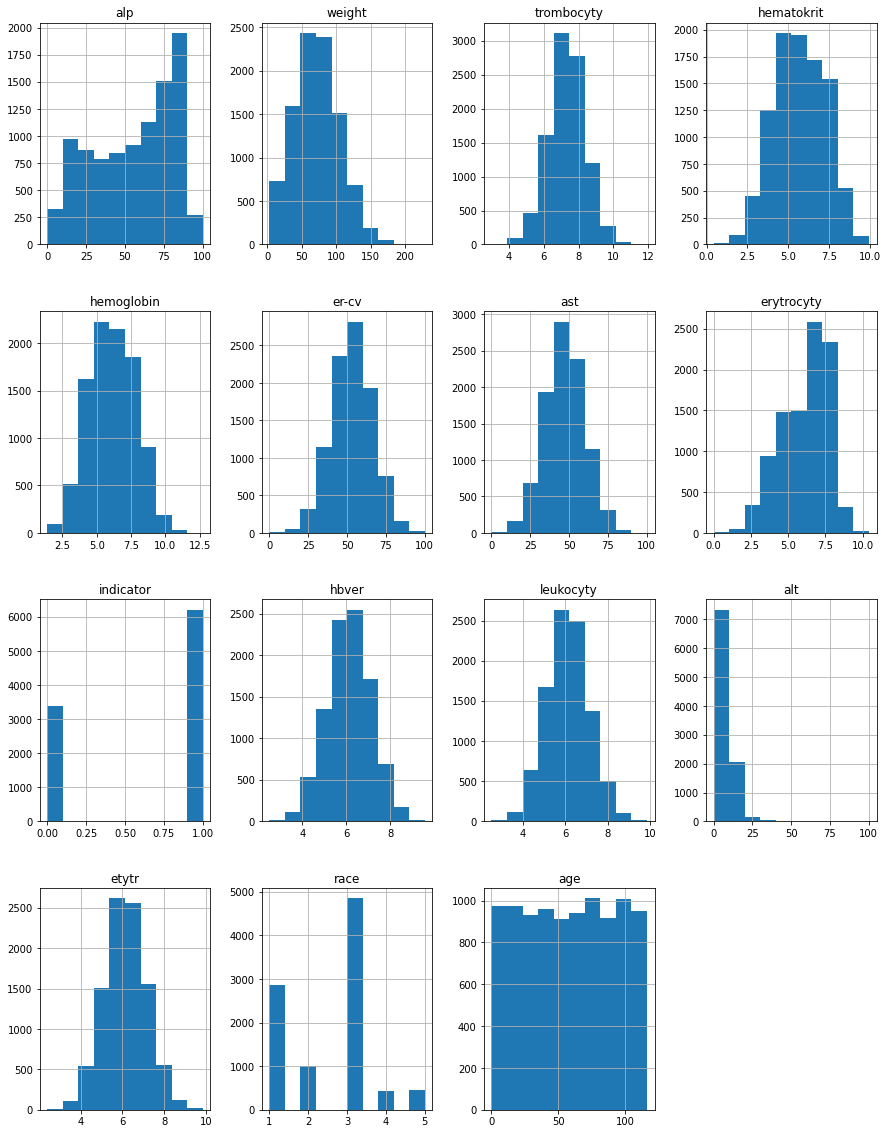

In [40]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
merged.hist(ax = ax)

Transformovať sme sa rozhodli všetky stĺpce, ktoré obsahujú merané numerické hodnoty. Taktiež použijeme túto techniku aj na nami vytvorený stĺpec age.

In [41]:
cols= ['alp','erytrocyty','etytr', 'hbver', 'ast', 'er-cv','age','alt','hemoglobin', 'hematokrit' ,'trombocyty', 'leukocyty','weight']
for column_name in cols:
    merged = remove_outlier(merged,column_name)

C:\Users\radov\AppData\Local\Temp/ipykernel_20264/1167618414.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  merged.hist(ax = ax)


array([[<AxesSubplot:title={'center':'alp'}>,
        <AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'trombocyty'}>,
        <AxesSubplot:title={'center':'hematokrit'}>],
       [<AxesSubplot:title={'center':'hemoglobin'}>,
        <AxesSubplot:title={'center':'er-cv'}>,
        <AxesSubplot:title={'center':'ast'}>,
        <AxesSubplot:title={'center':'erytrocyty'}>],
       [<AxesSubplot:title={'center':'indicator'}>,
        <AxesSubplot:title={'center':'hbver'}>,
        <AxesSubplot:title={'center':'leukocyty'}>,
        <AxesSubplot:title={'center':'alt'}>],
       [<AxesSubplot:title={'center':'etytr'}>,
        <AxesSubplot:title={'center':'race'}>,
        <AxesSubplot:title={'center':'age'}>, <AxesSubplot:>]],
      dtype=object)

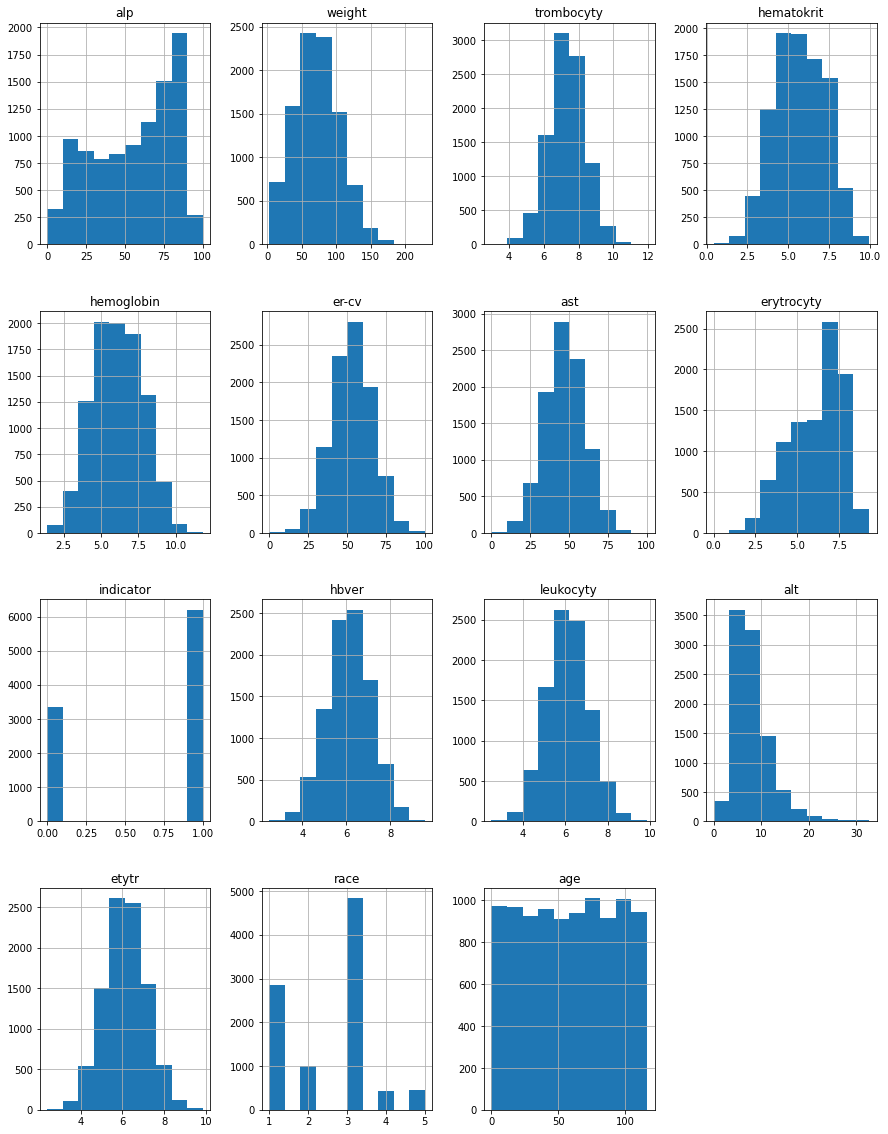

In [42]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
merged.hist(ax = ax)

# Realizácia predspracovania dát

Najskôr si prehodíme všetky numerické atribúty, ktoré sme pretransformovali zo strginov na typ numeric aby sme s nimi mohli ďalej pracovať. 

In [43]:
merged["smoker"] = pd.to_numeric(merged["smoker"])
merged["relationship"] = pd.to_numeric(merged["relationship"])
merged["race"] = pd.to_numeric(merged["race"])
merged["sex"] = pd.to_numeric(merged["sex"])
merged["smoker"] = pd.to_numeric(merged["smoker"])
merged["blood_group"] = pd.to_numeric(merged["blood_group"])
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9553 entries, 0 to 10040
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   relationship  9553 non-null   int64  
 1   smoker        9553 non-null   int64  
 2   alp           9553 non-null   float64
 3   weight        9553 non-null   float64
 4   trombocyty    9553 non-null   float64
 5   hematokrit    9553 non-null   float64
 6   hemoglobin    9553 non-null   float64
 7   er-cv         9553 non-null   float64
 8   ast           9553 non-null   float64
 9   ssn           9553 non-null   object 
 10  erytrocyty    9553 non-null   float64
 11  indicator     9553 non-null   float64
 12  hbver         9553 non-null   float64
 13  leukocyty     9553 non-null   float64
 14  alt           9553 non-null   float64
 15  etytr         9553 non-null   float64
 16  name          9553 non-null   object 
 17  blood_group   9553 non-null   int64  
 18  birthdate     9553 non-null

Rozhodli sme sa rozdeliť si dataset na testovaciu a trénovaciu množinu v pomere 1:4 teda 20% dát tvoria testovacie dáta a 80% trénovacie dáta. Ďalej budeme spracovávať trénovaciu vzorku.

In [44]:
len(merged)

9553

In [45]:
train_data, test_data = train_test_split(merged, test_size=0.2)
print('Trénovací dataset obsahuje:'+ str(len(train_data))+' záznamov\n'+'Testovacia vzorka obsahuje:'+  str(len(test_data))+' záznamov')

Trénovací dataset obsahuje:7642 záznamov
Testovacia vzorka obsahuje:1911 záznamov


Podľa histogramov po odstránení outlierov sme zistili, že niektoré hodnoty sú z iného ako normálového rozdelenia, preto sme si rozdelili atribúty podľa distribúcie.

In [46]:
skewed=['alp','erytrocyty']
transformed_atributes=['sex','race','blood_group','smoker','relationship','indicator']
gaussian=['weight', 'trombocyty', 'hematokrit', 'hemoglobin', 'er-cv', 'ast', 'alt', 'hbver', 'leukocyty', 'etytr']

Môžeme vidieť, že atribúty alp a alt majú nepravidelne rozdielné hodnoty, v jednotlivých kvantiloch. Preto ich transformujeme pomocou quantilového transformera.  

C:\Users\radov\AppData\Local\Temp/ipykernel_20264/1707975513.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train_data[skewed].hist(ax = ax)


array([[<AxesSubplot:title={'center':'alp'}>,
        <AxesSubplot:title={'center':'erytrocyty'}>]], dtype=object)

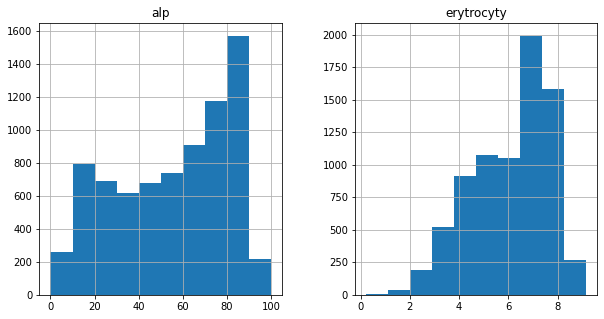

In [47]:
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
train_data[skewed].hist(ax = ax)


C:\Users\radov\AppData\Local\Temp/ipykernel_20264/2116364140.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train_data[skewed].hist(ax = ax)


array([[<AxesSubplot:title={'center':'alp'}>,
        <AxesSubplot:title={'center':'erytrocyty'}>]], dtype=object)

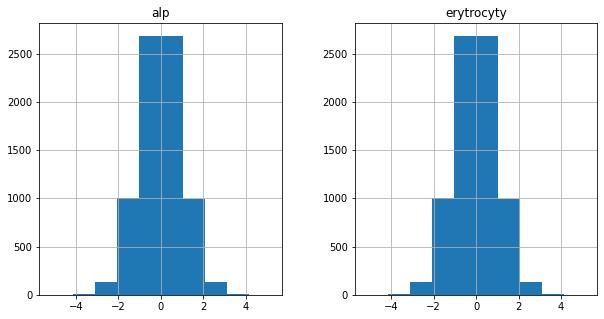

In [48]:
qt = QuantileTransformer(output_distribution="normal",n_quantiles=1000)
train_data[skewed] = qt.fit_transform(train_data[skewed])
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
train_data[skewed].hist(ax = ax)

Nami vytvorený atribút *age* potrebujeme taktiež transformovať ale potrebujeme kladné hodnoty takže použijeme vekový priemer.

<AxesSubplot:>

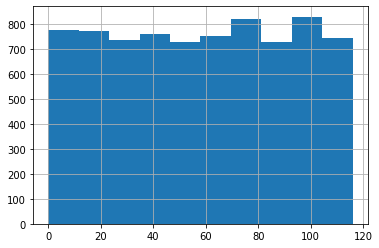

In [49]:
train_data['age'].hist()

In [50]:
age_mean = np.mean(train_data[['age']])
train_data[['age']] = qt.fit_transform(train_data[['age']])
train_data[['age']] *= 10
train_data[['age']] += age_mean
index_agess = train_data[(train_data.age <20)|(train_data.age > 85)].index
train_data.drop(index_agess, inplace = True)

<AxesSubplot:>

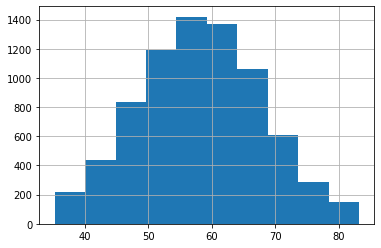

In [51]:
train_data['age'].hist()

Následovné atribúty zobrazené v týchto histogramoch sú nami transformované stĺpce, na ktoré sme použili MinMaxScaler aj napriek tomu, že to nebolo nevynutné.

C:\Users\radov\AppData\Local\Temp/ipykernel_20264/3985480200.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train_data[transformed_atributes].hist(ax = ax)


array([[<AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'race'}>],
       [<AxesSubplot:title={'center':'blood_group'}>,
        <AxesSubplot:title={'center':'smoker'}>],
       [<AxesSubplot:title={'center':'relationship'}>,
        <AxesSubplot:title={'center':'indicator'}>]], dtype=object)

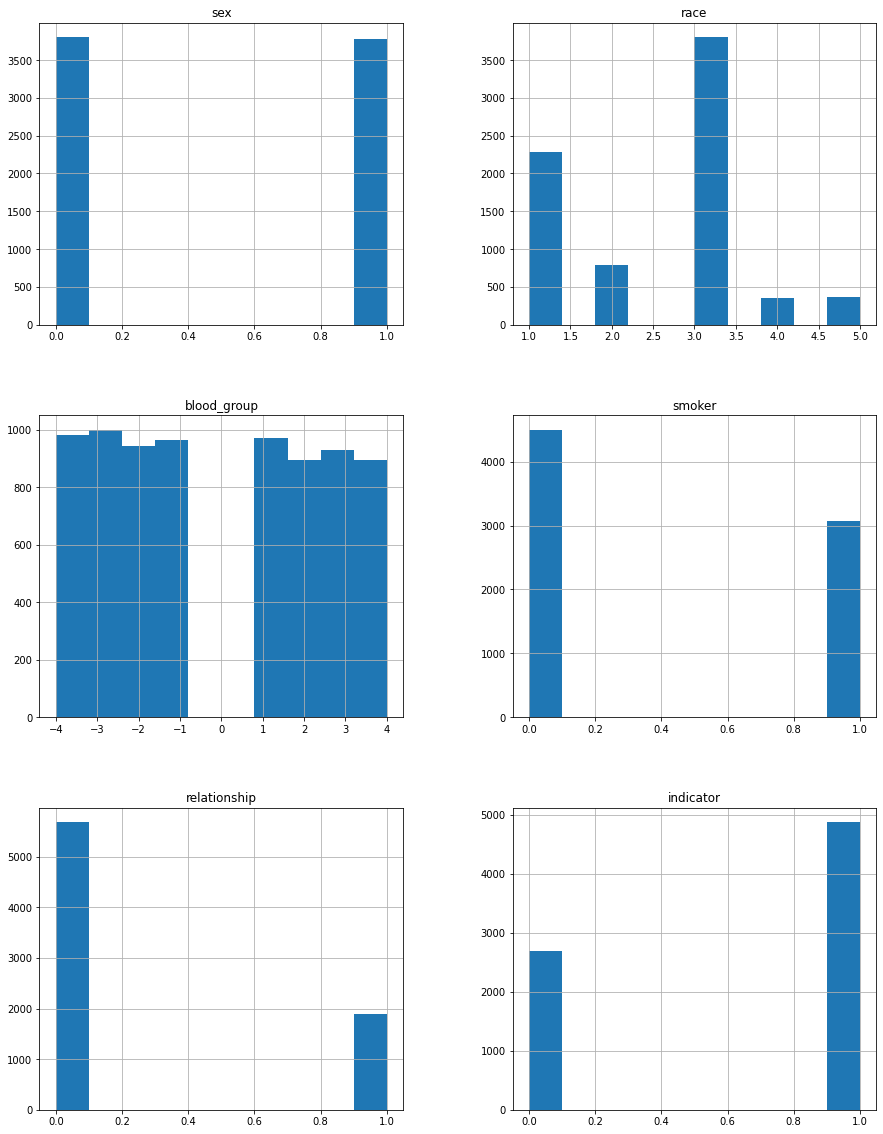

In [52]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train_data[transformed_atributes].hist(ax = ax)

Na ostatné merané atribúty sme sa rozhodli použiť poweer transformation s metódou Yeo-Johnson. Keďže po odstránení outlierov hodnoty týchto atribútov sú nesymetricky rozdelené.

C:\Users\radov\AppData\Local\Temp/ipykernel_20264/4084925039.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train_data[gaussian].hist(ax = ax)


array([[<AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'trombocyty'}>,
        <AxesSubplot:title={'center':'hematokrit'}>],
       [<AxesSubplot:title={'center':'hemoglobin'}>,
        <AxesSubplot:title={'center':'er-cv'}>,
        <AxesSubplot:title={'center':'ast'}>],
       [<AxesSubplot:title={'center':'alt'}>,
        <AxesSubplot:title={'center':'hbver'}>,
        <AxesSubplot:title={'center':'leukocyty'}>],
       [<AxesSubplot:title={'center':'etytr'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

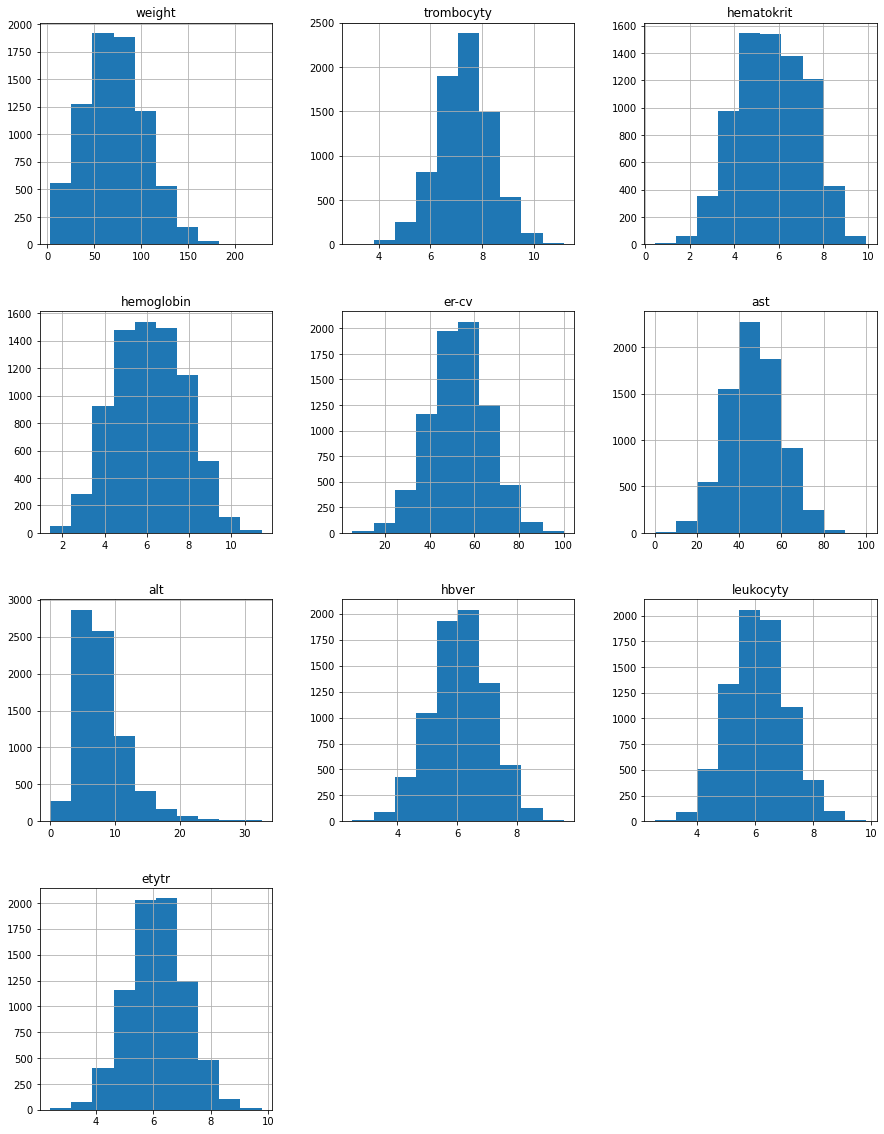

In [53]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train_data[gaussian].hist(ax = ax)

In [54]:
power = PowerTransformer(method='yeo-johnson', standardize=True) 
train_data[gaussian] = power.fit_transform(train_data[gaussian])

Posledný krok pre normalizovanie atribútov je použiť standard scaler na všetky nekategorické atribúty, okrem atribútu vek, ten sme si upravili špeciálne.

In [55]:
standard_scaler = StandardScaler()
train_data[gaussian+skewed] = standard_scaler.fit_transform(train_data[gaussian+ skewed])

C:\Users\radov\AppData\Local\Temp/ipykernel_20264/2748110766.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train_data.hist(ax = ax)


array([[<AxesSubplot:title={'center':'relationship'}>,
        <AxesSubplot:title={'center':'smoker'}>,
        <AxesSubplot:title={'center':'alp'}>,
        <AxesSubplot:title={'center':'weight'}>],
       [<AxesSubplot:title={'center':'trombocyty'}>,
        <AxesSubplot:title={'center':'hematokrit'}>,
        <AxesSubplot:title={'center':'hemoglobin'}>,
        <AxesSubplot:title={'center':'er-cv'}>],
       [<AxesSubplot:title={'center':'ast'}>,
        <AxesSubplot:title={'center':'erytrocyty'}>,
        <AxesSubplot:title={'center':'indicator'}>,
        <AxesSubplot:title={'center':'hbver'}>],
       [<AxesSubplot:title={'center':'leukocyty'}>,
        <AxesSubplot:title={'center':'alt'}>,
        <AxesSubplot:title={'center':'etytr'}>,
        <AxesSubplot:title={'center':'blood_group'}>],
       [<AxesSubplot:title={'center':'race'}>,
        <AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'age'}>, <AxesSubplot:>]],
      dtype=object)

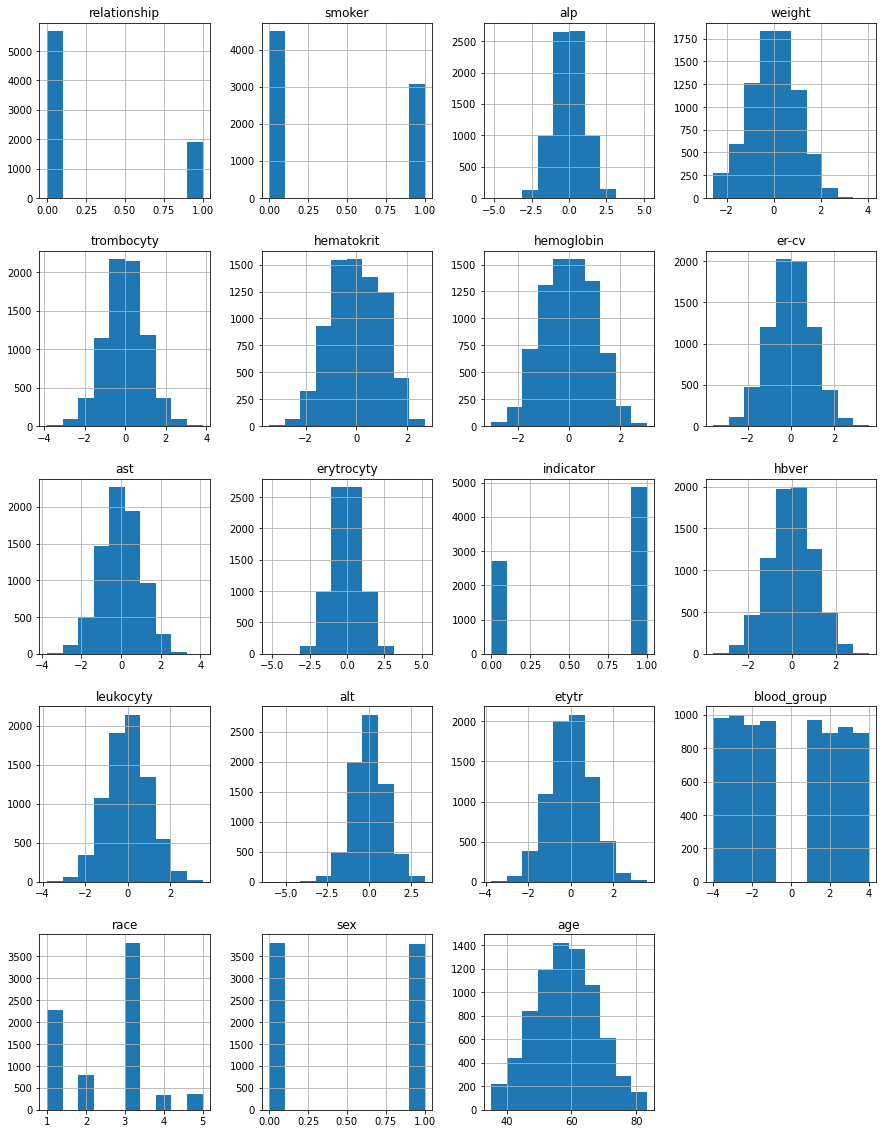

In [56]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train_data.hist(ax = ax)

# Výber atribútov pre strojové učenie

V datasete sa nachádza viacero informatívnych atribútov k atribútu indicator, ktorý reprezentuje stav pacienta. Podľa heat mapy môžeme vidieť, že niektoré atribúty s ním korelujú viac a niektoré menej, ale v podstate sú k nemu aj tak informatívne.

**Heatmapa pred transformáciou dát.**

<AxesSubplot:>

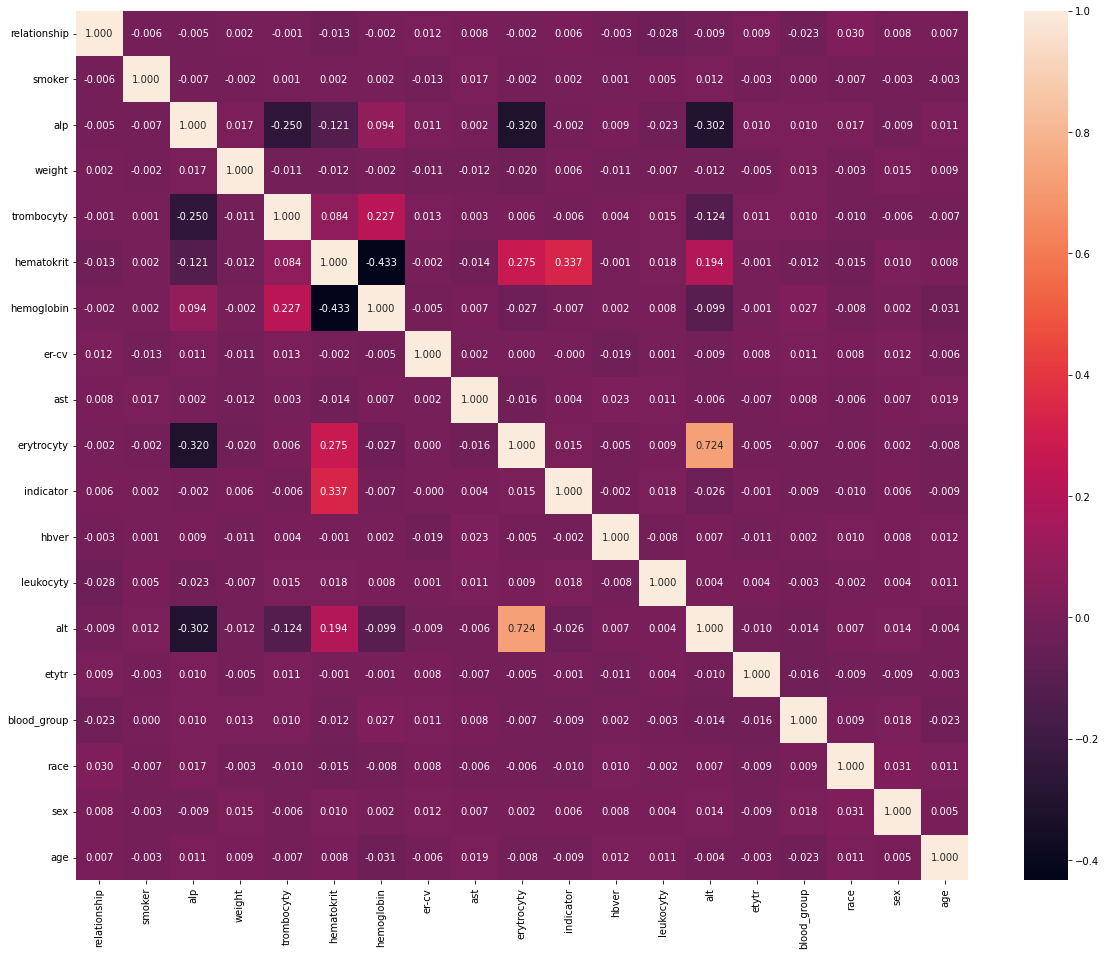

In [57]:
figure, ax = plt.subplots(figsize=(20,16))
sns.heatmap(merged.corr(),ax=ax, annot =True, fmt = ".3f")

**Heatmapa po transformácii dát.**

<AxesSubplot:>

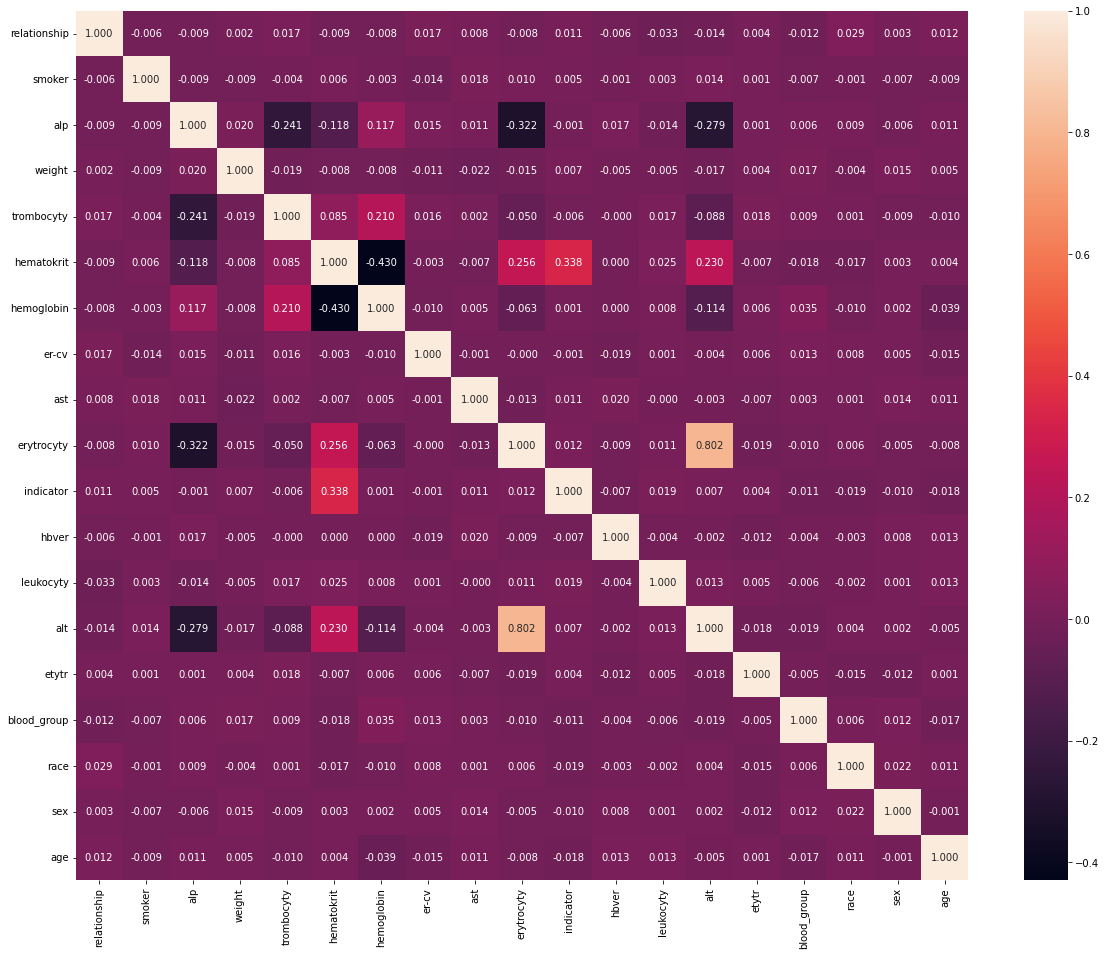

In [58]:
figure, ax = plt.subplots(figsize=(20,16))
sns.heatmap(train_data.corr(),ax=ax, annot =True, fmt = ".3f")

Ako porvé dáme preč úplne všetky nenumerické atribúty keďže tie sú v tejto časti zbytočné.

In [59]:
numeric_train_data = train_data.select_dtypes([np.number])

In [60]:
print (numeric_train_data.dtypes)

relationship      int64
smoker            int64
alp             float64
weight          float64
trombocyty      float64
hematokrit      float64
hemoglobin      float64
er-cv           float64
ast             float64
erytrocyty      float64
indicator       float64
hbver           float64
leukocyty       float64
alt             float64
etytr           float64
blood_group       int64
race              int64
sex               int64
age             float64
dtype: object


Ako máme možnosť vidieť, korelácie k atribútu indicator su veľmi nízke, kvôli tomu, že sme transformovali všetky atribúty a korelačná relácia k jednotlivým atribútom sa signifikantne nezmenila.

In [61]:
cor_target = abs(numeric_train_data.corr()["indicator"])
cor_target.sort_values(ascending=False)

indicator       1.000000
hematokrit      0.337759
leukocyty       0.019361
race            0.018665
age             0.017516
erytrocyty      0.011513
blood_group     0.011280
ast             0.010886
relationship    0.010634
sex             0.009758
alt             0.007235
weight          0.006651
hbver           0.006558
trombocyty      0.006413
smoker          0.005154
etytr           0.004028
alp             0.001366
hemoglobin      0.001321
er-cv           0.000854
Name: indicator, dtype: float64

Na tomto grafe môžme vidieť ako veľmi sú jednotlivé features informatívne k atribútu indicator. Bohužiaľ náš dataset vykazuje jediný vysoko korelačný atribút a to atribút hematokrit.

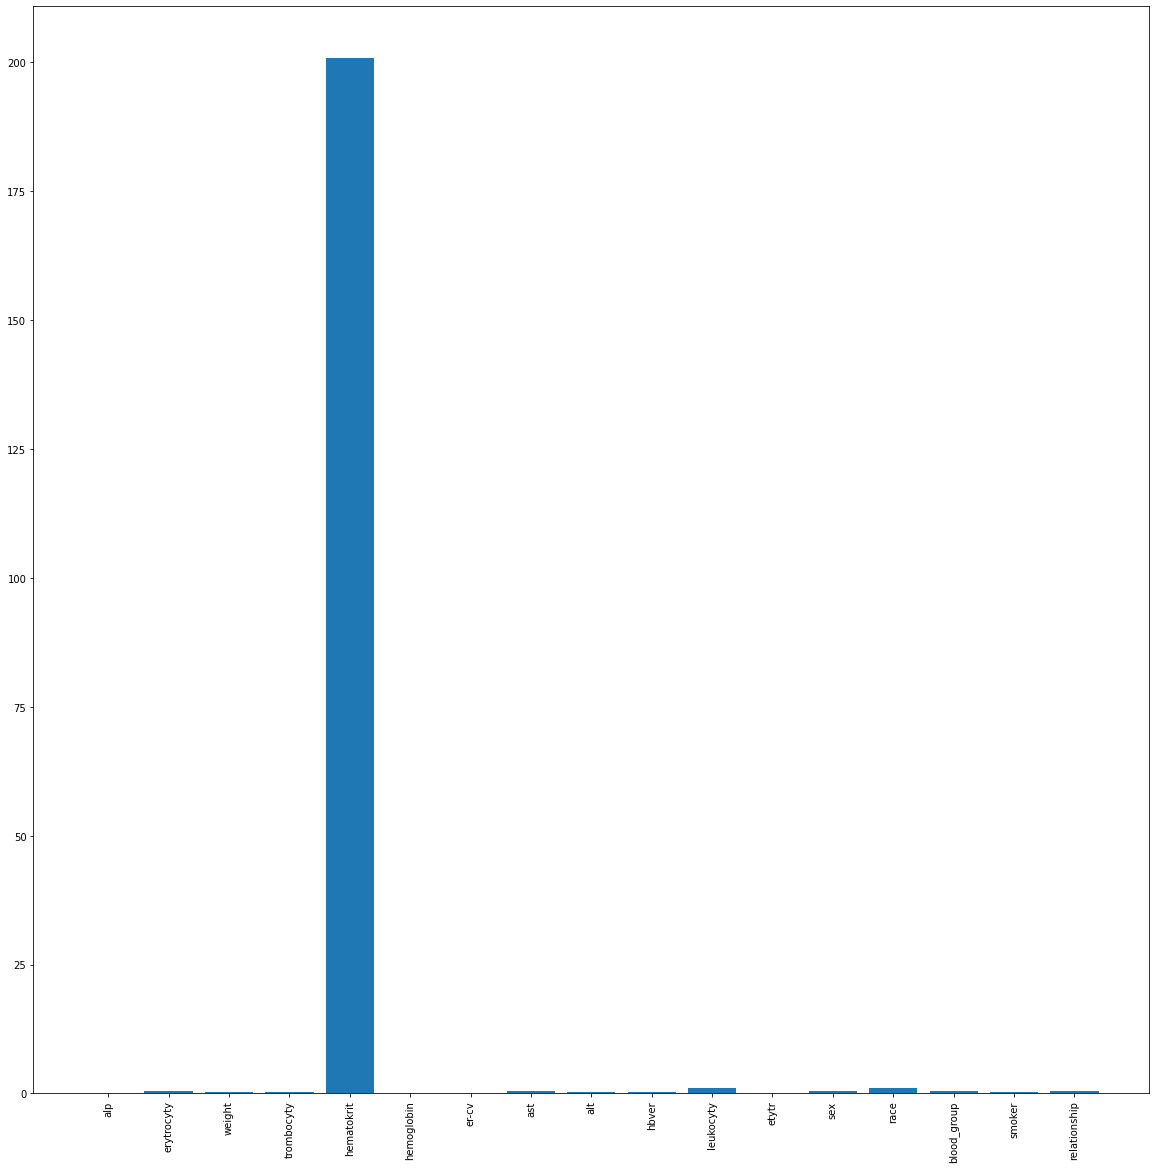

In [64]:
all=skewed+gaussian+['sex','race','blood_group','smoker','relationship']
selector = SelectKBest(f_regression, k=17)
selector.fit_transform(numeric_train_data[all], numeric_train_data["indicator"])
scores = -np.log10(selector.pvalues_)
plt.figure(figsize=(20, 20))
plt.bar(range(len(all)), scores)
plt.xticks(range(len(all)), all, rotation='vertical')
plt.show()

# Replikovateľnosť predspracovania 

Na demonštráciu predspracovania údajov sme využili pipeline. V tejto pipeline sa postupne vykonajú všetky transformácie jednotlivých atribútov. V podstate je to to isté, čo sme robili akurát jednoduhším a prehľadnejším spôsobom.

In [65]:
def columns_name_to_index(arr_of_names, df):
    return [df.columns.get_loc(c) for c in arr_of_names if c in df]

In [66]:
quantil_transformer = make_column_transformer((QuantileTransformer(output_distribution="normal",
                                               random_state=0,
                                               n_quantiles=1000),
                                               columns_name_to_index(skewed,numeric_train_data)),
                                               remainder='passthrough')


In [67]:
power_transformer = make_column_transformer((PowerTransformer(method='yeo-johnson',standardize=True),columns_name_to_index(gaussian,numeric_train_data)),remainder='passthrough')


In [68]:
standard_scaler = make_column_transformer((StandardScaler(),columns_name_to_index(gaussian+skewed,numeric_train_data)),remainder='passthrough')


In [69]:
pp = Pipeline(steps=[('1',quantil_transformer),
                     ('2',power_transformer),
                     ('3',standard_scaler),
                     ("4",FunctionTransformer(lambda x: pd.DataFrame(x, columns = numeric_train_data.columns)))], verbose=True)


In [70]:
transformed= pp.fit_transform(numeric_train_data)
transformed

[Pipeline] ................. (step 1 of 4) Processing 1, total=   0.0s
[Pipeline] ................. (step 2 of 4) Processing 2, total=   0.1s
[Pipeline] ................. (step 3 of 4) Processing 3, total=   0.0s
[Pipeline] ................. (step 4 of 4) Processing 4, total=   0.0s


,relationship,smoker,alp,weight,trombocyty,hematokrit,hemoglobin,er-cv,ast,erytrocyty,indicator,hbver,leukocyty,alt,etytr,blood_group,race,sex,age
0,0.067828,1.131219,0.328558,-1.228013,-0.986651,0.117352,-0.945542,-0.539892,-0.577757,0.744132,0.969773,-1.563963,1.210514,0.180003,-0.453920,-1.0,1.0,1.0,52.375329
1,-0.249275,-1.100715,-1.008041,-0.228219,-0.187134,-0.132727,-0.275126,-0.346408,-0.577757,-1.343847,-1.254324,-1.822476,-0.826096,-0.902835,-0.637009,-3.0,2.0,1.0,65.781042
2,-1.663257,-0.091506,0.488514,1.990942,-1.040200,-0.326456,-0.363549,2.011703,-0.577757,-1.343847,-2.043493,0.265252,1.210514,-1.375604,1.199099,-4.0,1.0,1.0,60.828774
3,0.290232,-1.534683,-0.149701,-0.095114,0.930534,-0.112126,0.401165,-0.559869,1.730832,-1.343847,-1.273086,-0.094320,1.210514,0.138858,-1.494245,-3.0,3.0,0.0,54.161937
4,-1.029057,0.576626,-1.214675,-0.243554,0.953378,1.128102,0.431504,-0.894908,-0.577757,0.744132,-0.035417,-0.316305,1.210514,0.825723,0.664272,-3.0,3.0,1.0,56.496115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7571,-0.661987,0.690824,0.757222,-0.350039,1.641488,-1.049047,-0.474619,-0.241942,-0.577757,-1.343847,0.355593,1.109118,-0.826096,-0.120205,0.383831,-1.0,1.0,1.0,63.067688
7572,1.208125,-1.384770,-1.422099,0.974145,-0.581500,0.270934,0.517066,1.347074,-0.577757,0.744132,-0.602756,-1.003401,-0.826096,-1.492459,-1.014385,2.0,3.0,1.0,64.943924
7573,1.297491,-0.800868,-1.096704,0.699567,-0.907900,-0.814897,-1.521346,0.538179,1.730832,0.744132,0.777480,-0.563631,-0.826096,0.345917,-0.290404,-3.0,3.0,1.0,66.089635
7574,1.131246,0.250164,0.787067,0.453003,-1.780808,-1.114992,1.546526,0.043987,1.730832,0.744132,0.459996,-1.302988,-0.826096,-1.689622,2.630234,-3.0,3.0,0.0,61.527544


## Záver

V tejto fáze projektu, sme po spojení datasetov, predspracovali dáta na strojové učenie. Podarilo sa nám nahradiť niektoré string atribúty za numerické hodnoty. Taktiež sme oddemonštrovali viaceré techniky nahradzovania nedefinovaných atribútov.  V rámci riešenia vychýlených hodnôt sme nahradili hodnoty pomocou kvantilového rozdelenia. V rámci zadania sme demonštovali  využitie Pipeline, ktorá bola využitá pri nahradzovaní null hodnôt a fázach transfomácie jednotlivých atribútov. Celková zmena datasetu oproti starému je vo formáte hodnôt a taktiež ich rozdelení. Výstupom tejto fázy je dataset pre strojové učenie.

In [71]:
numeric_train_data.head()

,relationship,smoker,alp,weight,trombocyty,hematokrit,hemoglobin,er-cv,ast,erytrocyty,indicator,hbver,leukocyty,alt,etytr,blood_group,race,sex,age
173,0,1,-0.453020,0.193490,0.969893,0.075858,1.128413,0.329300,-0.945542,-0.540574,1.0,-0.986721,0.117093,-1.224816,-1.562955,-1,1,1,52.375329
1840,0,0,-0.635187,-0.901115,-1.252363,-0.241749,-1.102782,-1.008138,-0.275126,-0.346766,0.0,-0.186159,-0.132984,-0.233128,-1.820951,-3,2,1,65.781042
4950,0,1,1.196390,-1.388469,-2.035063,-1.676383,-0.083804,0.489123,-0.363549,2.011514,0.0,-1.040379,-0.326683,2.005323,0.264607,-4,1,1,60.828774
9792,1,1,-1.494123,0.152621,-1.270995,0.297382,-1.544715,-0.148864,0.401165,-0.560451,0.0,0.930569,-0.112385,-0.100336,-0.095022,-3,3,0,54.161937
3629,0,1,0.663320,0.828547,-0.038371,-1.029952,0.581218,-1.215150,0.431504,-0.895308,1.0,0.953369,1.128197,-0.248412,-0.316923,-3,3,1,56.496115


In [72]:
test_data.head()

,relationship,smoker,alp,weight,trombocyty,hematokrit,hemoglobin,er-cv,ast,ssn,...,leukocyty,alt,etytr,name,blood_group,birthdate,race,job,sex,age
1256,1,0,89.02782,49.24571,6.86377,7.79416,5.69365,36.55715,46.52201,412-17-0721,...,5.77285,6.26040,5.11803,Elijah Mullins,2,1949-05-07,1,"Administrator, charities/voluntary organisations",1,72
9528,0,0,11.78973,69.26551,6.14013,8.02904,3.68625,31.88898,52.33032,486-37-6888,...,5.49033,18.50549,5.13882,Kimberly Wright,1,1934-07-13,3,Architectural technologist,0,87
2008,1,0,33.55305,68.09476,7.02363,4.86757,4.14963,80.08021,41.77232,689-01-3748,...,6.57406,8.10506,5.22415,Michelle Hawkins,-3,1935-05-24,3,Interior and spatial designer,0,86
3602,1,1,50.16796,96.06665,4.66269,3.90756,4.94506,56.64569,44.34450,294-46-8446,...,6.50250,8.28246,6.44052,Dawn Osborne,-2,2021-07-09,4,Regulatory affairs officer,0,0
7316,0,0,46.53602,92.12508,7.57351,5.22961,7.95275,55.43277,62.02863,590-85-8173,...,5.53583,17.61189,5.74870,Sandra Sharp,-2,1948-04-19,2,Medical physicist,0,73


In [73]:
numeric_train_data.to_csv('train_transformed.csv')

In [74]:
test_data.to_csv('test_data.csv')